# Converting the Sentinel-2 Imagery from .SAFE to Cloud-Optimized Zarr Format


The Sentinel-SAFE format is a variation of the [Standard Archive Format for Europe (SAFE)](https://user.eumetsat.int/resources/user-guides/sentinel-safe-format-guide). It is a zip-compressed container for storing Sentinel satellite images in different spatial resolutions, and their metadata. While it is a well-established standard format for archiving satellite data, it is not optimized for high-performance cloud computing workflows due to its data structure and large volume.

In this Jupyter Notebook we will __learn how to convert Sentinel-2 images from SAFE container to multidimensional arrays and store them in a new [.zarr data format](https://zarr.dev/)__, optimized for cloud storage.

The main advantages of Zarr format are:
- support of data chunking - dividing data into small, independently stored subsets;
- compression algorithms;
- parallel reading and writing operations.

All this makes it highly efficient for cloud computing, effectively distributing resources and reducing server latency, enabling real-time analytics and processing. \
Therefore, reformating large satellite Sentinel-2 multidimensional rasters into Zarr format will improve their performance in a cloud environment.

### Outline

1. [Install and import necessary Python packages](#1.-Install-and-import-necessary-Python-packages)
2. [Download Sentinel-2 imagery in .SAFE Format from Copernicus Data Space](#2.-Download-Sentinel-2-Imagery-in-.SAFE-Format-from-Copernicus-Data-Space)
3. [Load Sentinel-2 imagery from .SAFE folder](#3.-Load-Sentinel-2-imagery-from-.SAFE-folder)
4. [Open Sentinel-2 images as data arrays, stack them, and convert to Zarr format](#4.-Open-Sentinel-2-images-as-data-arrays,-stack-them,-and-convert-to-Zarr-format)
5. [Validate the Zarr file](#5.-Validate-the-Zarr-file)
6. [Upload Zarr data to cloud storage (optional)](#6.-Upload-Zarr-data-to-cloud-storage-(optional))

### 1. Install and import necessary Python packages

Install packages using pip install (might take some time)

In [ ]:
!pip install dask google-cloud-storage matplotlib numpy pandas rasterio rioxarray requests xarray zarr==2.18.4

<div class="alert alert-info">
<b>Note:</b>
Zarr version 3 is a major update released in Jan 2025, which brings significant changes in Zarr file structure and metadata format. Some services might be incompatible with the new format specification, as the migration is still in progress. For now, it is recommended to use Zarr v2.18.4
</div>

Import packages

In [1]:
import matplotlib.pyplot as plt #plotting
import numpy as np #array manipulation
import os #file handling
import pandas as pd #data manipulation
import requests #HTTP requests
import rioxarray #xarray extension, opens jp2 files as data arrays
import zipfile #unzipping files
import xarray as xr #multi-dimensional arrays manipulation
import zarr #cloud-optimized multidimensional arrays storage
from utils import extract_sensing_time, create_gcs_bucket, upload_folder_to_gcs #helper functions

### 2. Download Sentinel-2 Imagery in .SAFE Format from Copernicus Data Space
To download the Sentinel-2 .SAFE archive we will use [Copernicus Data Space Ecosystem](https://dataspace.copernicus.eu/) (CDSE), new European Space Agency portal for access to Copernicus satellite data. It has [various APIs](https://dataspace.copernicus.eu/analyse/apis) for programmatic data access, but for Sentinel data downloading we will need only [OData API](https://documentation.dataspace.copernicus.eu/APIs/OData.html).

If you don't have a CDSE account, you can [register here](https://identity.dataspace.copernicus.eu/auth/realms/CDSE/login-actions/registration?client_id=cdse-public&tab_id=AUttuJFdXdw).

Process:
1. Authenticate with Copernicus Data Space API using your login credentials
2. Search for Sentinel-2 products using OData API
3. Download the selected product in .SAFE format

You can skip this step if you want to use the existing Sentinel-2 .SAFE file from your computer.\
In this case, you can proceed to [Step 3 - Loading Sentinel-2 imagery from .SAFE folder](#3.-Loading-Sentinel-2-imagery-from-.SAFE-folder)

Alternatively, you can download the .SAFE zip manually, using the graphic interface of [Copernicus Data Space Ecosystem Browser](https://browser.dataspace.copernicus.eu/), central hub for accessing, exploring and utilizing Earth observation and environmental data. Just extract the archive to the same folder as this notebook.

#### Create token
To download data via API we need to generate a temporary [access token](https://documentation.dataspace.copernicus.eu/APIs/Token.html). To do so, authenticate with CDSE API with your login credentials using ``requests`` - simple HTTP library for Python, which allows sending HTTP requests and handling responses. [Full documentation available here](https://requests.readthedocs.io/en/latest/).

In [ ]:
#Enter your Copernicus Data Space login credentials
#Also, you can hardcode your username and password to not type them every time
USERNAME = input("Enter your CDS username (email): ") 
PASSWORD = input("Enter your CDS password: ")
TOKEN_URL = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"

#Request an access token (VALID ONLY FOR 10 MINUTES)
token_response = requests.post( #Send POST request to the token URL
    TOKEN_URL,
    headers={"Content-Type": "application/x-www-form-urlencoded"},
    data={
        "username": USERNAME,
        "password": PASSWORD,
        "grant_type": "password",
        "client_id": "cdse-public",
    },
)

#Check for successful authentication
if token_response.status_code == 200:
    access_token = token_response.json().get("access_token")
    print("Access token retrieved")
else:
    print("Failed to get access token:", token_response.text)
    access_token = None

####  Get Sentinel-2 product ID
Every Sentinel SAFE container (product) has a unique ID. We need to make a search query to [OData API](https://documentation.dataspace.copernicus.eu/APIs/OData.html) to get it. To narrow down the search, we can filter available Sentinel images by data source, area and sensing dates.
In this example, we will search only for images from the most recently launched satellite - Sentinel-2C, Level-2A - with atmospheric correction (``S2C_MSIL2A``), and low cloud coverage over Munich in March 2025.\
The area around Munich is used just for example, you are encouraged to choose any other location you like. You can use [bboxfinder](http://bboxfinder.com) to get the bounding box for your area of interest. \
Also, to convert the API response to DataFrame, we will use ``pandas`` - popular library for data manipulation and analysis ([pandas documentation](https://pandas.pydata.org/docs/)).

Troubleshooting:
- ``JSONDecodeError: Expecting value: line 1 column 1 (char 0)``: means that access token is expired, you need to request a new one.

In [5]:
#Define area of interest (bounding box) in WGS84 coordinates (longitude, latitude)
#Copy the bbox coordinates from bboxfinder.com and paste below
bbox_wgs84 = (11.45, 48.09, 11.69, 48.21) #min lon, min lat, max lon, max lat

#Convert bbox to POLYGON format (coordinates must be in clockwise order and closed)
polygon = (
    f"SRID=4326;POLYGON(({bbox_wgs84[0]} {bbox_wgs84[1]}, "
    f"{bbox_wgs84[2]} {bbox_wgs84[1]}, "
    f"{bbox_wgs84[2]} {bbox_wgs84[3]}, "
    f"{bbox_wgs84[0]} {bbox_wgs84[3]}, "
    f"{bbox_wgs84[0]} {bbox_wgs84[1]}))"
)

#Define the sensing date range (e.g. March 2025)
date_from = "2025-03-01T00:00:00.000Z"
date_to   = "2025-03-31T23:59:59.999Z"
#Define what is the max acceptable percentage of clouds on the image
cloud_cover = 30.00 #Note that the cloud coverage is calculated as % of the total Sentinel-2 image area, not the area of interest

#Construct query to OData API using filters by geographic criteria, product name, date range, and cloud coverage
query = (
    "https://catalogue.dataspace.copernicus.eu/odata/v1/Products?"
    "$filter=OData.CSC.Intersects(area=geography'" f"{polygon}') "
    "and contains(Name, 'S2C_MSIL2A') and " #Get Sentinel-2C Level-2A high-quality image products
    f"ContentDate/Start gt {date_from} and ContentDate/Start lt {date_to} and " #Set date range
    "Attributes/OData.CSC.DoubleAttribute/any(att: att/Name eq 'cloudCover' "
    f"and att/OData.CSC.DoubleAttribute/Value lt {cloud_cover})" #Set max % of cloud coverage
)

#Send authenticated request
headers = {"Authorization": f"Bearer {access_token}"}
response = requests.get(query, headers=headers)
data = response.json()

if "value" in data and len(data["value"]) > 0:
    df = pd.DataFrame.from_dict(data['value']) #Convert response to pandas DataFrame
    
    #Select relevant columns to print
    print(df[['Id', 'Name', 'GeoFootprint']].head(3)) #Print first 3 products found
    
    #Select the first matching Sentinel-2 product from search results
    product_id = df.iloc[0]['Id']
    product_name = df.iloc[0]['Name']

    print(f"\nSelected Product: {product_name}")
    print(f"Product ID: {product_id}")
else:
    print("No products found. Response text:", response.text)

                                     Id  \
0  1ba0786f-bc3d-4eeb-81f5-94fa45525a58   
1  4e2b90e7-3387-411b-b866-63a9bde00d5a   
2  986505bd-6f15-4548-bbb0-8b28edb939de   

                                                Name  \
0  S2C_MSIL2A_20250303T100951_N0511_R022_T32UPU_2...   
1  S2C_MSIL2A_20250306T101931_N0511_R065_T32UPU_2...   
2  S2C_MSIL2A_20250306T101931_N0511_R065_T32UQU_2...   

                                        GeoFootprint  
0  {'type': 'Polygon', 'coordinates': [[[10.58093...  
1  {'type': 'Polygon', 'coordinates': [[[10.36027...  
2  {'type': 'Polygon', 'coordinates': [[[12.57460...  

Selected Product: S2C_MSIL2A_20250303T100951_N0511_R022_T32UPU_20250303T155811.SAFE
Product ID: 1ba0786f-bc3d-4eeb-81f5-94fa45525a58


####  Download Sentinel-2 SAFE archive using product ID

Finally, we can use product ID to make a request to download the selected Sentinel-2 product in zipped .SAFE format.\
To test the workflow, ``product_id = "4e2b90e7-3387-411b-b866-63a9bde00d5a"`` was used first.

In [6]:
#Download .SAFE archive using the product ID
download_url = f"https://download.dataspace.copernicus.eu/odata/v1/Products({product_id})/$value"

#Set up headers for authentication
headers = {"Authorization": f"Bearer {access_token}"}

#Download the .SAFE archive
S2_SAFE = "S2_SAFE_product.zip"
with requests.get(download_url, headers=headers, stream=True) as response:
    response.raise_for_status()
    with open(S2_SAFE, "wb") as file:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)

print(f"Downloaded: {S2_SAFE}")

Downloaded: S2_SAFE_product.zip


### 3. Load Sentinel-2 imagery from .SAFE folder
Sentinel-2 SAFE folder contains multiple subfolders with metadata and images in 10m, 20m, and 60m spatial resolutions (pixel sizes) for 
13 spectral bands in visible, near-infrared, and short-wave infrared wavelength ranges. More information about Sentinel-2 bands and their possible combinations are available [here](https://gisgeography.com/sentinel-2-bands-combinations).

Too keep it simple, we will focus on images with 10m resolution from Red (B04), Green (B03), and Blue (B02) bands. The goal will be to create a natural color band combination (RGB image) from these bands, and convert it into Zarr format. If the conversion is successful, resulting Zarr file should look like a true-color satellite image.

However, you can experiment with other bands and resolutions following the same workflow.

Unzip the archive with standard ``zipfile`` module ([documentation](https://docs.python.org/3/library/zipfile.html)).

In [7]:
#Unzip the archive
with zipfile.ZipFile("S2_SAFE_product.zip", "r") as zip_ref:
    zip_ref.extractall(".") #Extract to the current directory

#Find the extracted .SAFE folder in the current directory
safe_folder = [f for f in os.listdir(".") if f.endswith(".SAFE")][0]
print(f"Extracted: {safe_folder}")

Extracted: S2C_MSIL2A_20250303T100951_N0511_R022_T32UPU_20250303T155811.SAFE


Use the standard ``os`` module ([documentation](https://docs.python.org/3/library/os.html)) to navigate through the .SAFE folder structure and locate the 10m resolution images for Red, Green, and Blue bands.\
If you already have the Sentinel-2 .SAFE folder, you can set your path here

In [8]:
#safe_folder="path to the .SAFE folder"

#Locate GRANULE subfolder inside the .SAFE structure
granule_path = os.path.join(safe_folder, "GRANULE")
granule_subfolder = next(os.scandir(granule_path)).path  #Assumes one granule present

#Locate folder with 10m resolution images inside the granule structure
r10m_folder = os.path.join(granule_subfolder, "IMG_DATA", "R10m")

#Build paths to Red, Green and Blue bands
band_paths = {}
for band, band_name in {"Red": "B04", "Green": "B03", "Blue": "B02"}.items():
    band_files = [f for f in os.listdir(r10m_folder) if f.endswith(f"_{band_name}_10m.jp2")]
    band_paths[band] = os.path.join(r10m_folder, band_files[0]) if band_files else None

#Print out found band paths
print("Band paths:", band_paths)

Band paths: {'Red': 'S2C_MSIL2A_20250303T100951_N0511_R022_T32UPU_20250303T155811.SAFE\\GRANULE\\L2A_T32UPU_A002566_20250303T100946\\IMG_DATA\\R10m\\T32UPU_20250303T100951_B04_10m.jp2', 'Green': 'S2C_MSIL2A_20250303T100951_N0511_R022_T32UPU_20250303T155811.SAFE\\GRANULE\\L2A_T32UPU_A002566_20250303T100946\\IMG_DATA\\R10m\\T32UPU_20250303T100951_B03_10m.jp2', 'Blue': 'S2C_MSIL2A_20250303T100951_N0511_R022_T32UPU_20250303T155811.SAFE\\GRANULE\\L2A_T32UPU_A002566_20250303T100946\\IMG_DATA\\R10m\\T32UPU_20250303T100951_B02_10m.jp2'}


### 4. Open Sentinel-2 images as data arrays, stack them, and convert to Zarr format

For this step we will use ``xaarray`` - a powerful library for working with multi-dimensional arrays in Python ([xarray documentation](http://xarray.pydata.org/en/stable/)), and ``rioxarray`` - an extension of ``xarray``. It's function [``rioxarray.open_rasterio``](https://corteva.github.io/rioxarray/html/rioxarray.html#rioxarray-open-rasterio) allows to open jp2 files directly as data arrays, unlike ``rasterio``, which cause error with jp2 files ([rioxarray documentation](https://corteva.github.io/rioxarray/stable/)).
The code below opens the Red, Green, and Blue bands as data arrays, extract necessary bands metadata to write attributes, and stack them together into a single DataArray.

Also, ``dask`` library is used in the background to perform chunking of the data arrays for parallel computing ([dask documentation](https://docs.dask.org/en/latest/)).


In [14]:
#Create empty list to store bands
bands_list = []
    
#Open each band as data array and append to list
for i, (band, path) in enumerate(band_paths.items(), start=1):
    band_data = rioxarray.open_rasterio(path, chunks={'x': 1000, 'y': 1000}) #set chunk size 
    
    #Extract metadata for attributes
    transform = band_data.rio.transform() #Affine transformation matrix
    resolution = band_data.rio.resolution() #Spatial resolution
    sensing_time = extract_sensing_time(os.path.basename(path)) #Get sensing time from the file name
    
    #Assign attributes to DataArray
    band_data = band_data.assign_coords(band=[i])  #Set band index (1, 2, 3)
    band_data.attrs.update({
        "transform": transform,
        "resolution": resolution,
        "sensing_time": sensing_time
    })
    
    #Append to the list
    bands_list.append(band_data)

We can now stack bands using [``xarray.concat``](https://docs.xarray.dev/en/stable/generated/xarray.concat.html) function to create a composite RGB image.

In [15]:
#Stack arrays along 'band' dimension
rgb_bands = xr.concat(bands_list, dim="band")

#See the resulting DataArray
rgb_bands

<xarray.DataArray (band: 3, y: 10980, x: 10980)> Size: 723MB
dask.array<concatenate, shape=(3, 10980, 10980), dtype=uint16, chunksize=(1, 1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 88kB 6e+05 6e+05 6e+05 ... 7.098e+05 7.098e+05
  * y            (y) float64 88kB 5.4e+06 5.4e+06 5.4e+06 ... 5.29e+06 5.29e+06
    spatial_ref  int64 8B 0
  * band         (band) int64 24B 1 2 3
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    transform:     | 10.00, 0.00, 600000.00|\n| 0.00,-10.00, 5400000.00|\n| 0...
    resolution:    (10.0, -10.0)
    sensing_time:  2025-03-03 10:09:51

Expected output:
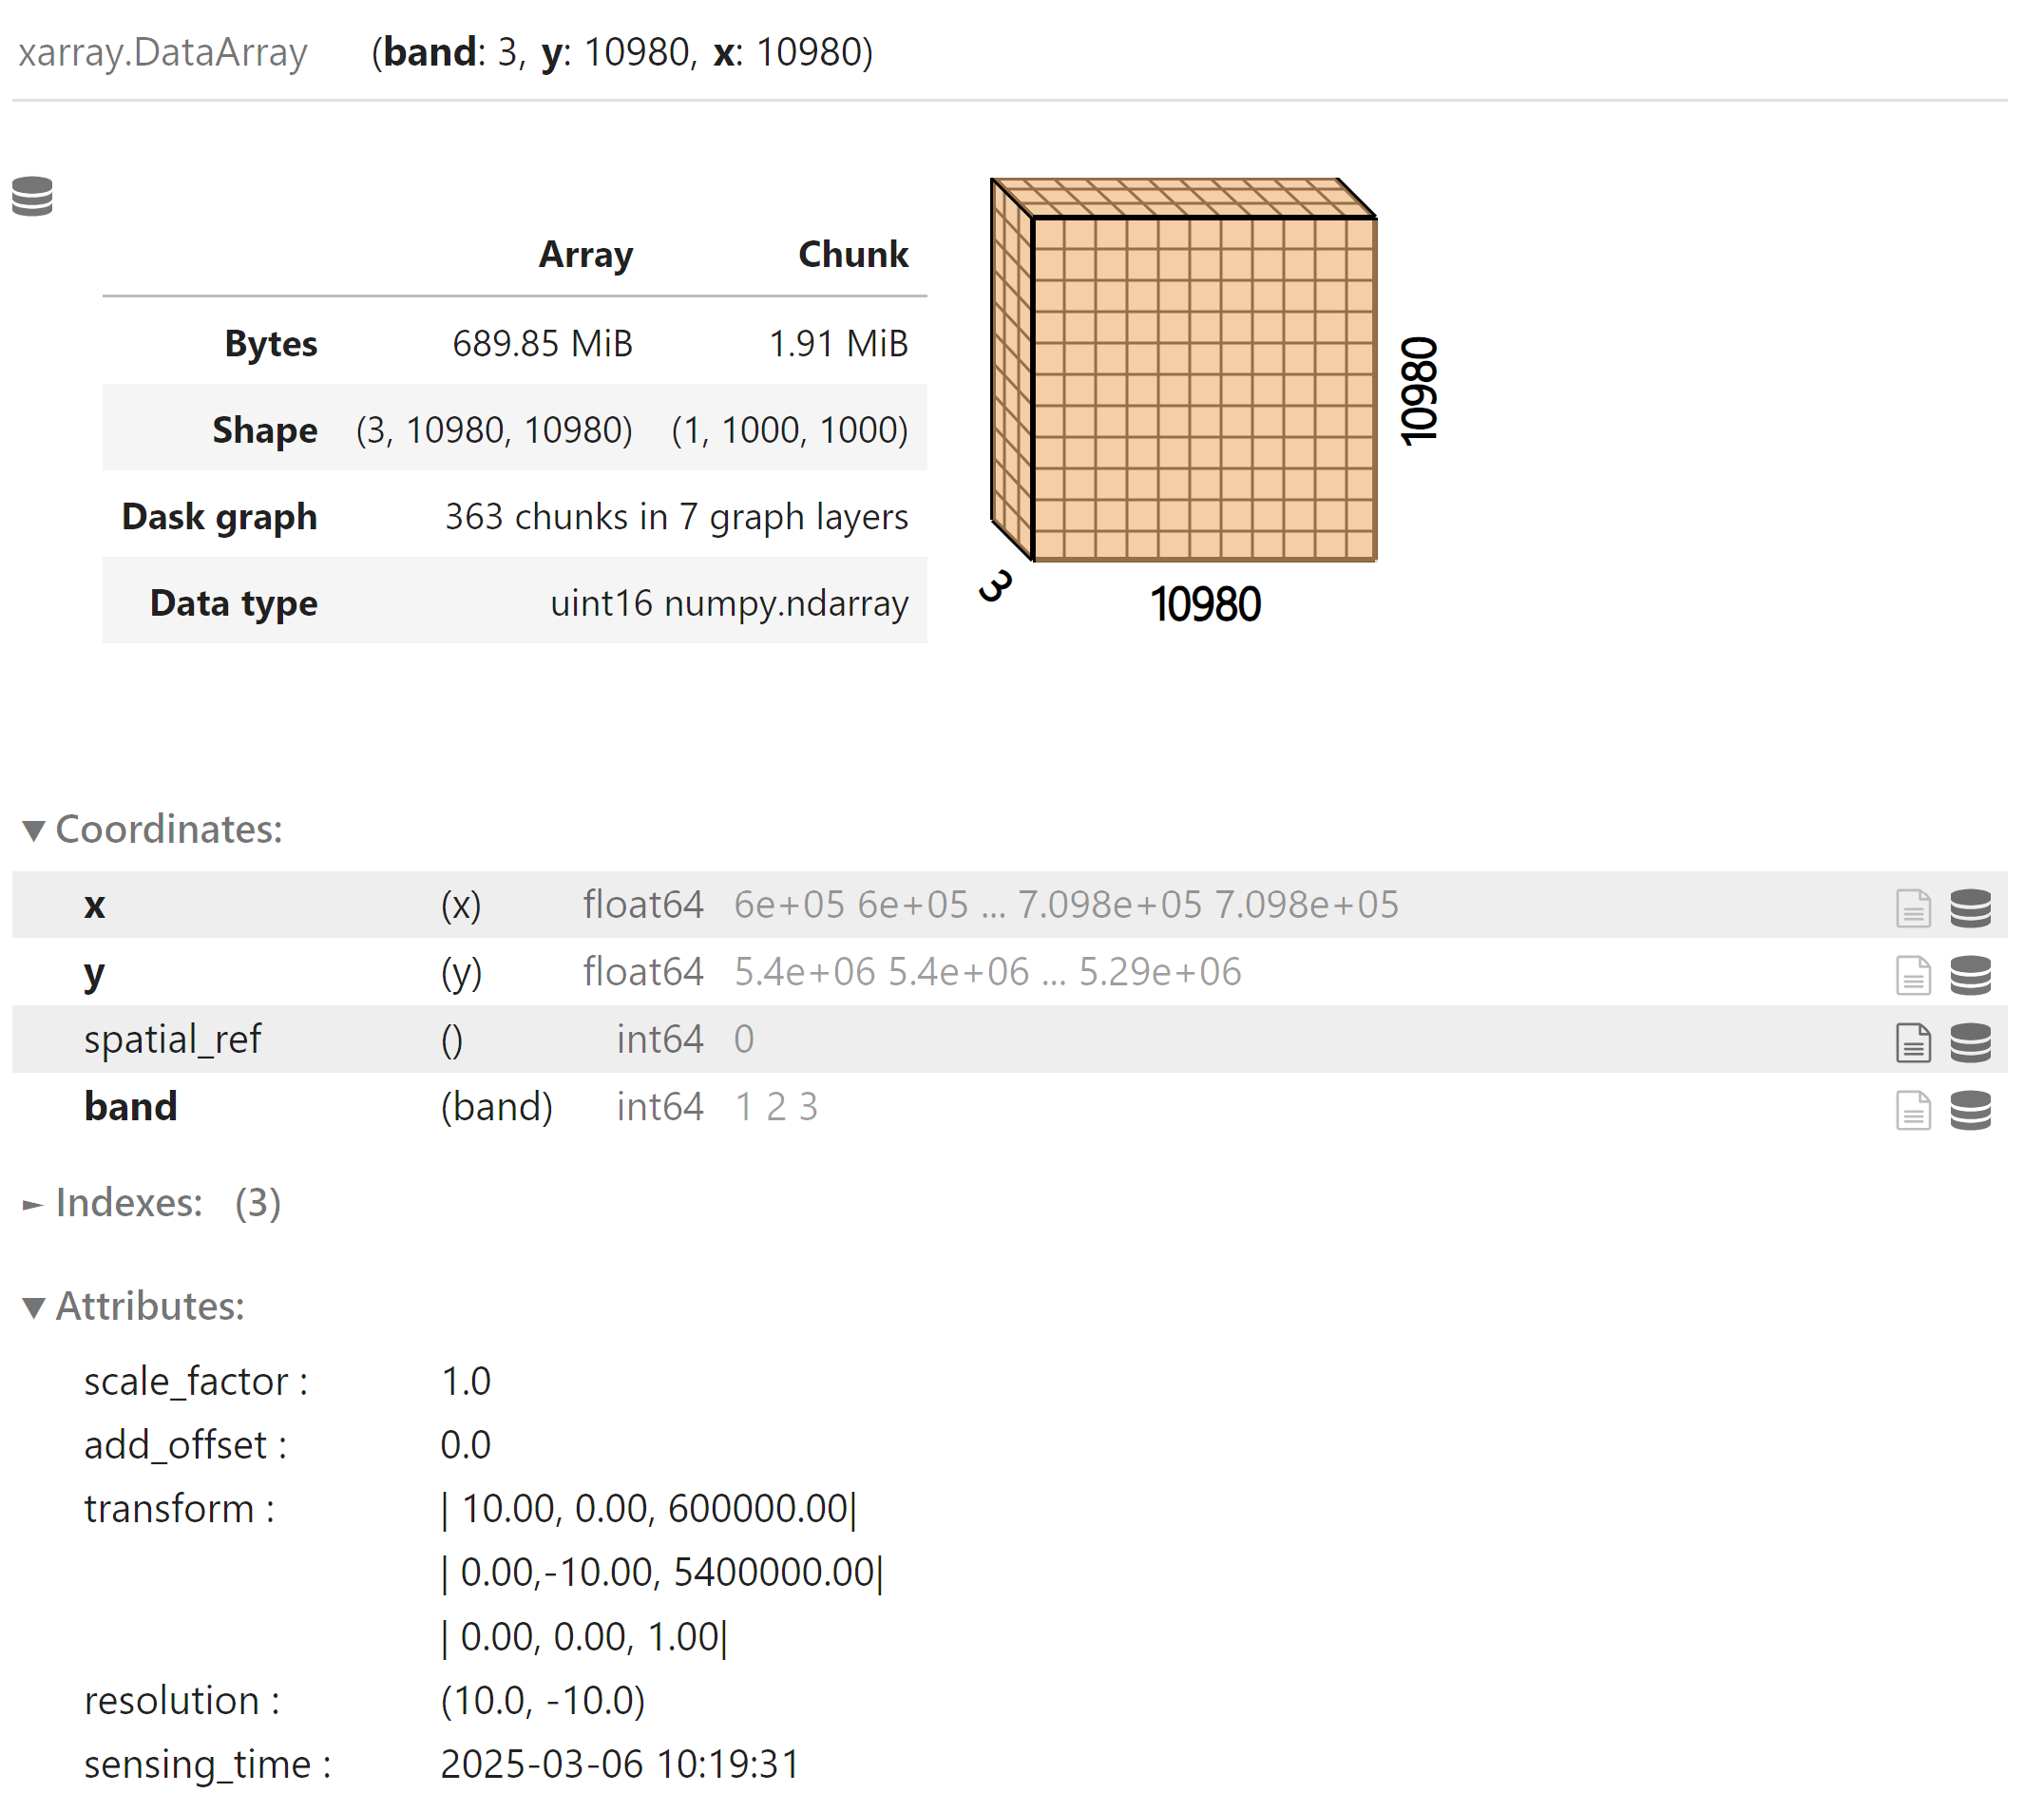


If the output is matching our expectations, we can convert the Data Array to Zarr format using the ``xarray`` method [``to_zarr``](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.to_zarr.html).\
[Zarr library](https://zarr.readthedocs.io/en/stable/) is working in the background.

In [16]:
#Convert xarray Data Array to Zarr format
rgb_bands.to_zarr("sentinel2_rgb.zarr", mode="w")

### 5. Validate the Zarr file

To make sure that the Zarr output is successful, we can:
- open the Zarr store and check its structure
- plot the image to see if the bands are correctly stacked
- drag and drop the zarr file into QGIS to visualize it

First, open the Zarr store using ``xarray``.

In [17]:
zarr_store = xr.open_zarr("sentinel2_rgb.zarr")
zarr_store

<xarray.Dataset> Size: 3GB
Dimensions:                        (band: 3, y: 10980, x: 10980)
Coordinates:
  * band                           (band) int64 24B 1 2 3
  * x                              (x) float64 88kB 6e+05 6e+05 ... 7.098e+05
  * y                              (y) float64 88kB 5.4e+06 5.4e+06 ... 5.29e+06
Data variables:
    __xarray_dataarray_variable__  (band, y, x) float64 3GB dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    spatial_ref                    int64 8B ...

Next, we can plot the dataset using ``matplotlib`` to see if the bands are correctly stacked.
Matplotlib is a popular plotting library for Python ([Matplotlib documentation](https://matplotlib.org/)).
To normalize the data for plotting, we will apply min-max scaling to the bands (using [``numpy.stack``](https://numpy.org/doc/stable/reference/generated/numpy.stack.html) and [``numpy.clip``](https://numpy.org/doc/stable/reference/generated/numpy.clip.html) functions), convert them to uint8 data type, and reorder the dimensions to (y, x, bands).

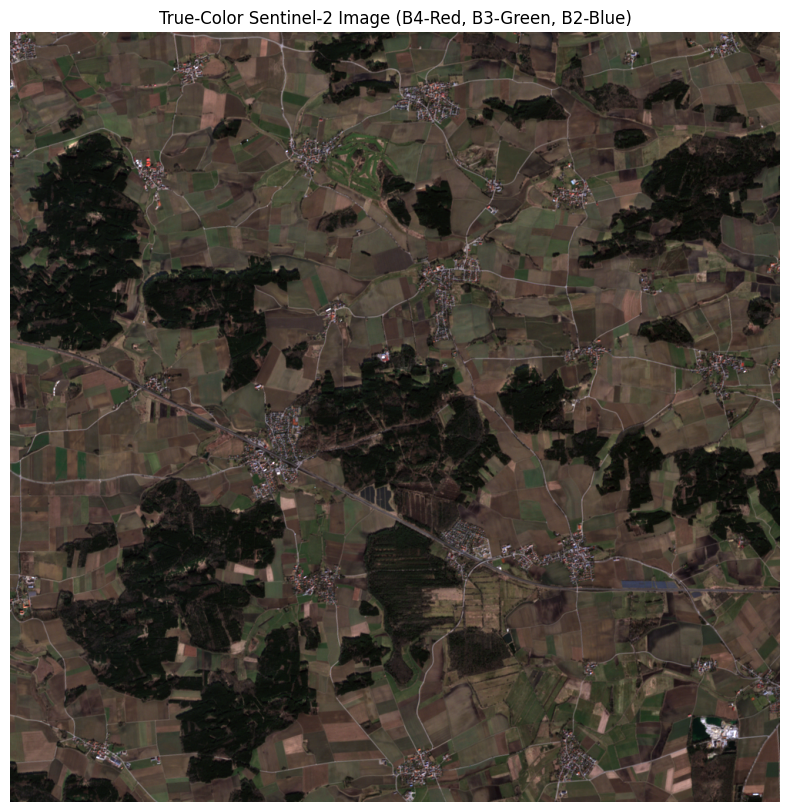

In [21]:
#Extract the data variable and subset the data - select only a portion for faster computation
bands_plot = zarr_store["__xarray_dataarray_variable__"].isel(y=slice(5000, 6000), x=slice(5000, 6000))

#Apply normalization correctly
normalized_bands = np.stack([
    (band.values - band.values.min()) / (band.values.max() - band.values.min())
    for band in bands_plot], axis=0) * 255

#Convert to uint8 data type and reorder dimensions to (y, x, bands)
rgb_array = normalized_bands.astype("uint8").transpose(1, 2, 0)

#Apply factor and clip range before plotting
factor = 2.5 / 255 #increase brightness
clip_range = (0, 1)
rgb_array = np.clip(rgb_array * factor, *clip_range)

#Plot using Matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(rgb_array)
plt.axis("off")
plt.title("True-Color Sentinel-2 Image (B4-Red, B3-Green, B2-Blue)")
plt.show()

Additionally, to validate the Zarr file, we can just drag and drop it into QGIS, selecting the "__xarray_dataarray_variable__" to add as a layer.
Here is the expected output:

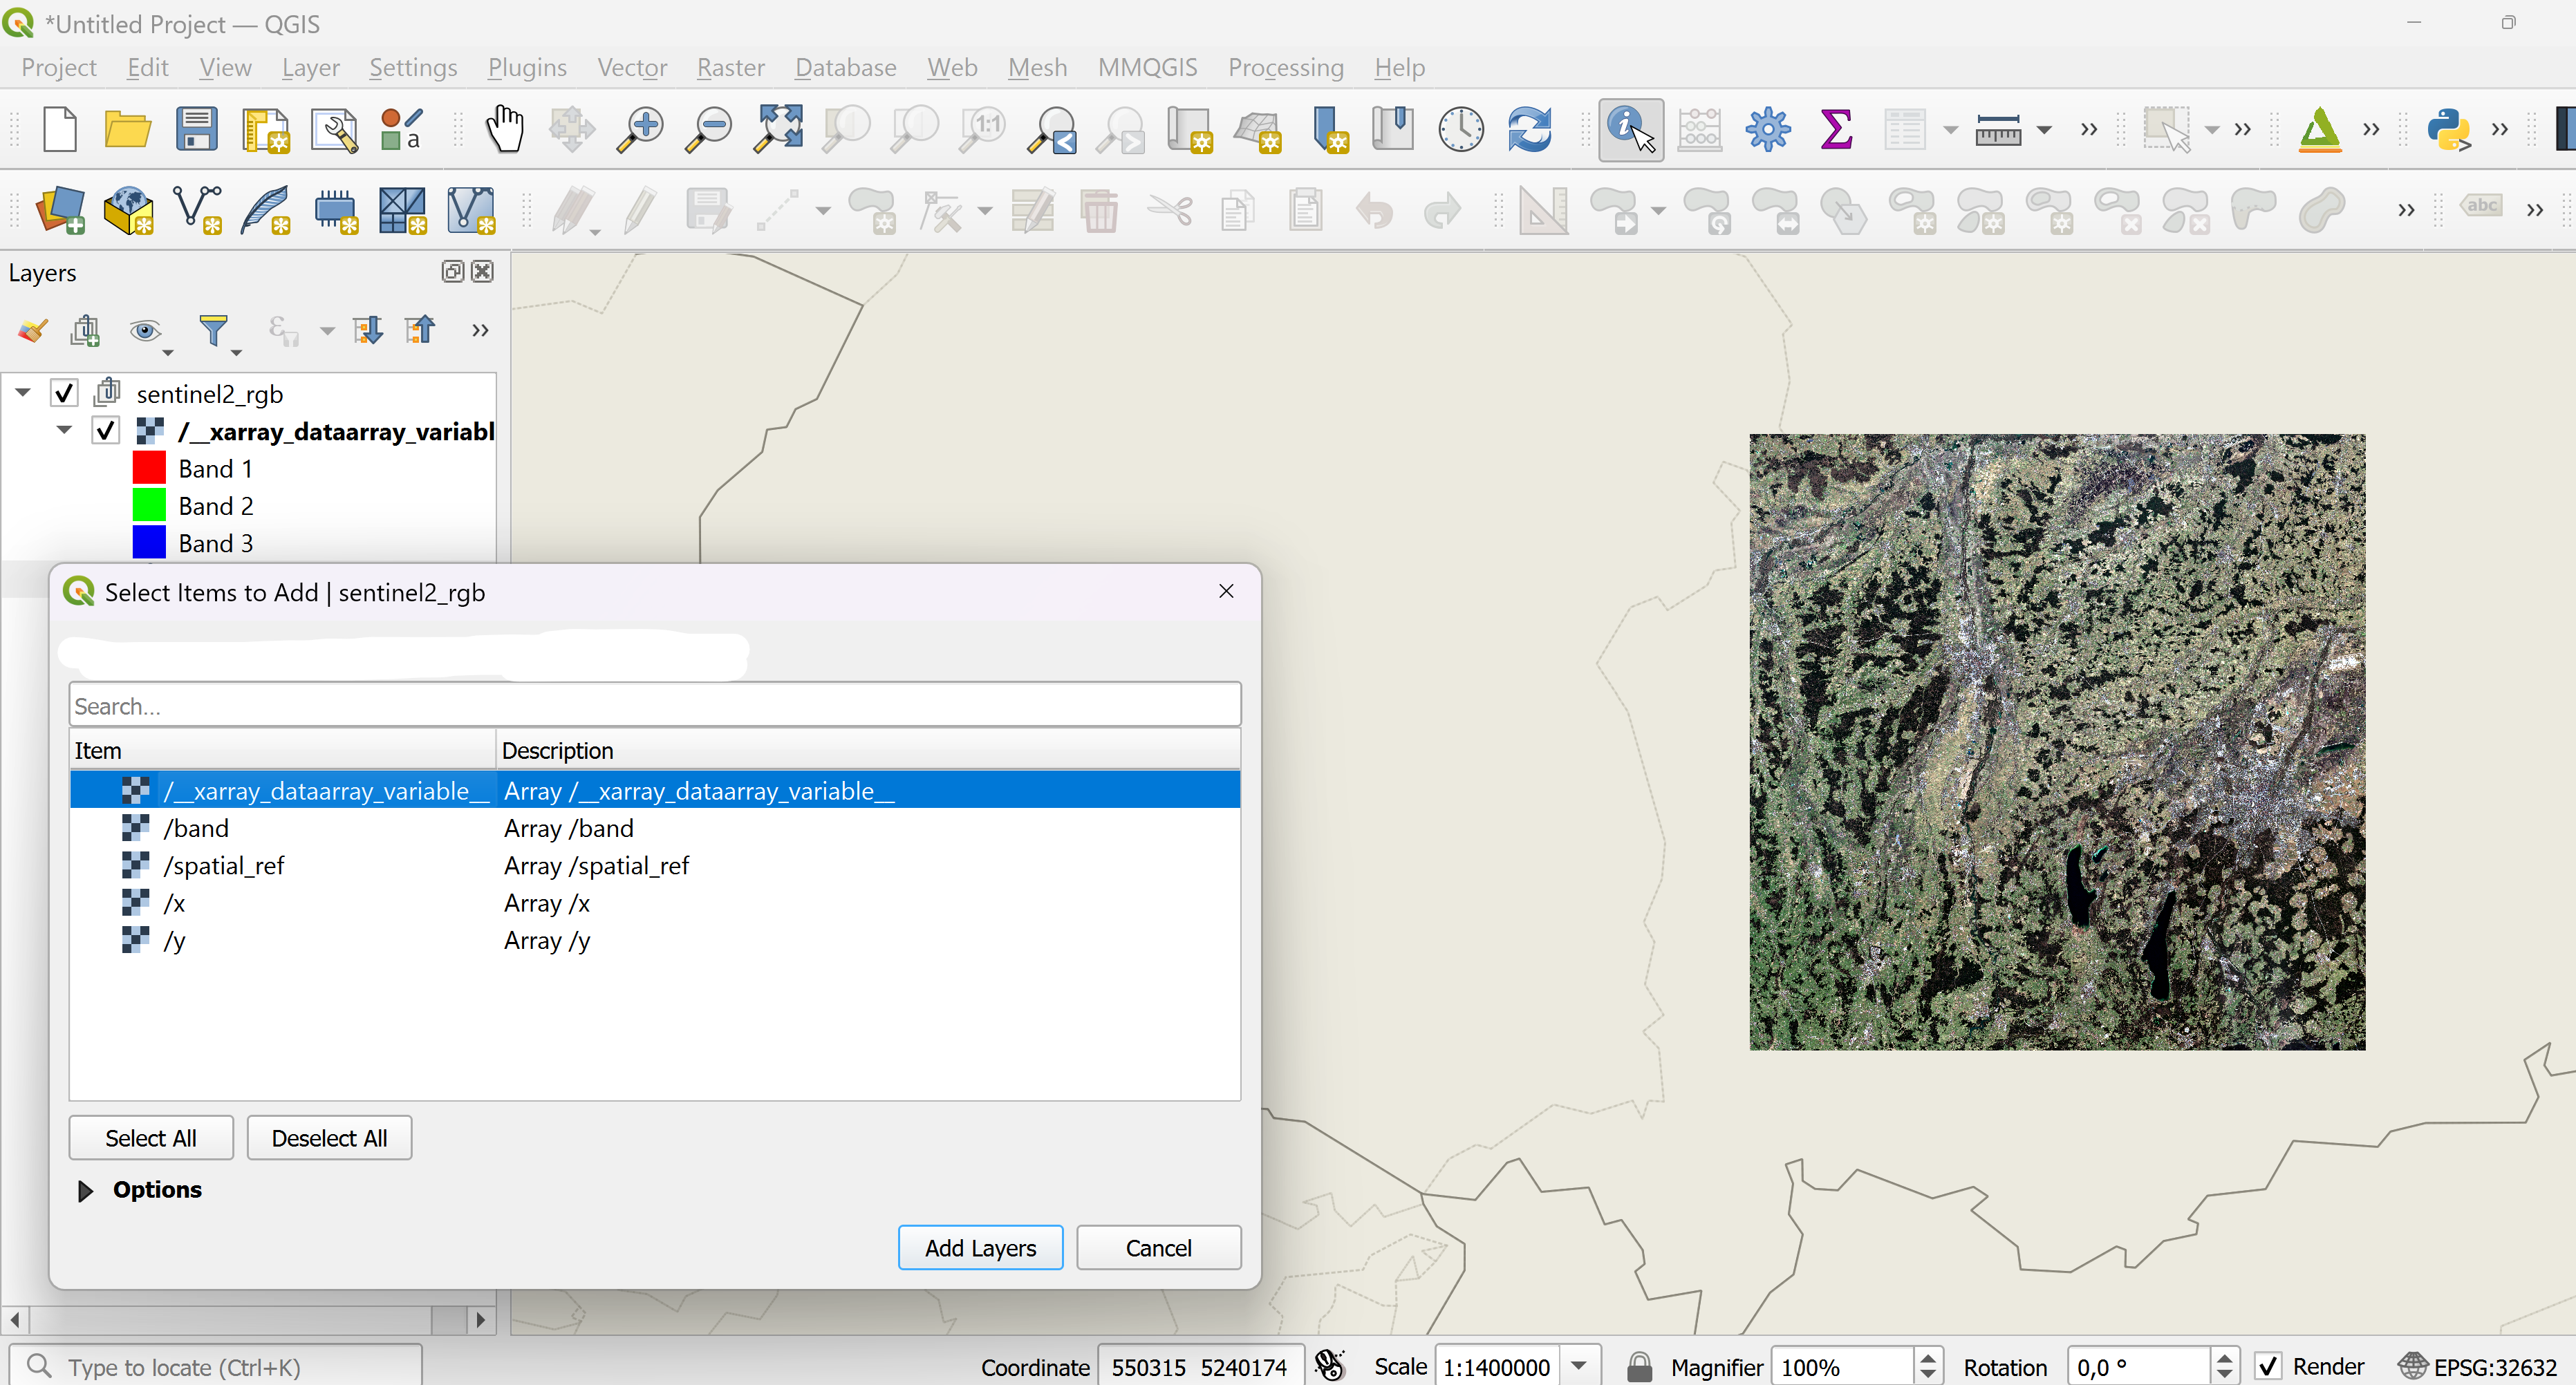


### 6. Upload Zarr data to cloud storage (optional)
Zarr is optimized to work with cloud storage services, so we can upload Zarr files to a cloud. Here is an example of how to upload the zarr file to Google Cloud Storage (GCS).\
We need to [create a Google Cloud account](https://console.cloud.google.com/freetrial/signup) with your Google account, create project and set up billing. To do so, you can follow the [Google Cloud Storage quickstart guide](https://console.cloud.google.com/welcome?walkthrough_id=storage--quickstart-basic-tasks&inv=1&invt=AbrvRA&project=fifth-curve-453410-e4).

*(This part of the workflow was not tested with an actual Google Cloud Storage, so it might be incomplete or contain some errors)*

To access Google Cloud Storage with python commands, you need a service account key.\
**Create a service account key**
1. In the Google Cloud console, go to the [Service accounts page](https://console.cloud.google.com/projectselector2/iam-admin/serviceaccounts?walkthrough_id=iam--create-service-account-keys&start_index=1&inv=1&invt=Abrs7A&supportedpurview=project#step_index=1)
2. Select a project
3. Click the email address of the service account that you want to create a key for
4. Click the Keys tab
5. Click the Add key drop-down menu, then select Create new key
6. Select JSON as the Key type and click Create
Clicking Create downloads a service account key file. After you download the key file, you cannot download it again
7. Move the key to the same folder as this notebook and set the GOOGLE_APPLICATION_CREDENTIALS environment variable 

In [ ]:
#Set the path to your service account key file
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "service_account_key.json" #edit path to the json key file if needed

Then, create a bucket - a container for objects stored in Cloud Storage.\
After that, you can upload the zarr file to the GCS bucket.\
Functions are defined in the utils.py file.

In [ ]:
#Choose a bucket name
bucket_name = "sentinel-2-gcs-bucket"

#Create a bucket
create_gcs_bucket(bucket_name)
    
#Path to Zarr folder
source = "sentinel2_rgb.zarr"

#Object name in GCS bucket
destination_blob = "sentinel2_rgb.zarr"

#Upload zarr file to GCS bucket
upload_folder_to_gcs(bucket_name, source, destination_blob)